In [80]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
sys.path.append('/home/jarauser/src/jaratest/maxh')
#sys.path.append('C:/Users/mdhor/Documents/GitHub/jaratest/maxh')
import oddball_analysis_functions as odbl
from jaratoolbox import celldatabase
from jaratoolbox import settings
from jaratoolbox import ephyscore
from jaratoolbox import spikesanalysis
from jaratoolbox import extraplots
from jaratoolbox import behavioranalysis

timeRangePlot = [-0.3, 0.45]
timeRangeStim = [0.015, 0.115]
timeRangeBaseline = [-0.2, 0]
baselineDuration = timeRangeBaseline[1] - timeRangeBaseline[0]
stimDuration = timeRangeStim[1] - timeRangeStim[0]


subject = 'acid006'

inforecFile = os.path.join(settings.INFOREC_PATH, f'{subject}_inforec.py')

celldb = celldatabase.generate_cell_database(inforecFile)
dbPath = os.path.join(settings.DATABASE_PATH ,f'celldb_{subject}.h5')

reagents = ('saline', 'doi')


nCells = len(celldb)

baselineFiringPureTones = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
stimAvgFiringPureTones = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
stimMaxAvgFiringPureTones = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
stimBestFrequency = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
gaussianAmplitude = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
gaussianMean = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
gaussianSigma = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
rSquaredColumn = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
upOddSpikesAvgFiringRate = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
downStandardSpikesAvgFiringRate = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
downOddSpikesAvgFiringRate = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
upStandardSpikesAvgFiringRate = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
upOddballIndex = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
downOddballIndex = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}


for indRow, dbRow in celldb.iterrows():
    oneCell = ephyscore.Cell(dbRow)

    for reagent in reagents:
        sessionType = f'{reagent}PureTones'
    
        ephysData, bdata = oneCell.load(sessionType)  
        spikeTimes = ephysData['spikeTimes']
        eventOnsetTimes = ephysData['events']['stimOn']

        
        frequencies_each_trial = bdata['currentFreq']
        array_of_frequencies = np.unique(bdata['currentFreq'])
        
        # Checks to see if trial count from bdata is the same as trial count from ephys
        if (len(frequencies_each_trial) > len(eventOnsetTimes)) or (len(frequencies_each_trial) < len(eventOnsetTimes)-1):
            print(f'Warning! BevahTrials ({len(frequencies_each_trial)}) and ' + f'EphysTrials ({len(eventOnsetTimes)})')
            sys.exit()

        # If the ephys data is 1 more than the bdata, delete the last ephys trial.
        if len(frequencies_each_trial) == len(eventOnsetTimes)-1:
            eventOnsetTimes = eventOnsetTimes[:len(frequencies_each_trial)]



        
        (spikeTimesFromEventOnset, trialIndexForEachSpike, indexLimitsEachTrial) = spikesanalysis.eventlocked_spiketimes(spikeTimes, eventOnsetTimes, timeRangePlot)

        trialsEachCond = behavioranalysis.find_trials_each_type(frequencies_each_trial, array_of_frequencies)

        spikeCountMatBase = spikesanalysis.spiketimes_to_spikecounts(spikeTimesFromEventOnset, indexLimitsEachTrial, timeRangeBaseline)
        spikeCountMatStim = spikesanalysis.spiketimes_to_spikecounts(spikeTimesFromEventOnset, indexLimitsEachTrial, timeRangeStim)

        baselineFiringPureTones[reagent][indRow] = np.mean(spikeCountMatBase) / baselineDuration

        nTrials = len(indexLimitsEachTrial[0])
        trialsEachCondInds, nTrialsEachCond, nCond= extraplots.trials_each_cond_inds(trialsEachCond, nTrials)

        firingRates = np.empty(nCond)
        for cond in range(trialsEachCond.shape[1]):
            nSpikesEachTrial = spikeCountMatStim[trialsEachCond[:,cond]]
            avgSpikes = np.mean(nSpikesEachTrial)
            spikesFiringRate = (avgSpikes / stimDuration)
            firingRates[cond] = spikesFiringRate
        avgFiringRate = np.mean(firingRates)
        maxAvgFiringRate = firingRates.max()
        bestFreq = array_of_frequencies[np.argmax(firingRates)]


        stimAvgFiringPureTones[reagent][indRow] = avgFiringRate
        stimMaxAvgFiringPureTones[reagent][indRow] = maxAvgFiringRate
        stimBestFrequency[reagent][indRow] = bestFreq

        try:
            possibleLogFreq = np.log2(array_of_frequencies)
            fitParams, RSquared = extraplots.fit_tuning_curve(possibleLogFreq, firingRates)

            gaussianAmplitude[reagent][indRow] = fitParams[0]
            gaussianMean[reagent][indRow] = fitParams[1]
            gaussianSigma[reagent][indRow] = fitParams[2]
            rSquaredColumn[reagent][indRow] = RSquared
        except:
            gaussianAmplitude[reagent][indRow] = np.nan
            gaussianMean[reagent][indRow] = np.nan
            gaussianSigma[reagent][indRow] = np.nan
            rSquaredColumn[reagent][indRow] = np.nan

        

    for reagent in reagents:
        sessionType = reagent
        spikeTimesFromEventOnsetUp, trialIndexForEachSpikeUp, indexLimitsEachTrialUp, upOdd, downStandard = odbl.main_function(oneCell, f'{sessionType}FM_Up', timeRangePlot)
        spikeTimesFromEventOnsetDown, trialIndexForEachSpikeDown, indexLimitsEachTrialDown, upStandard, downOdd = odbl.main_function(oneCell, f'{sessionType}FM_Down', timeRangePlot)

        trialsBeforeOddDownStd = odbl.trials_before_oddball(upOdd)       
        trialsBeforeOddUpStd = odbl.trials_before_oddball(downOdd)

        spikeCountMatUp = spikesanalysis.spiketimes_to_spikecounts(spikeTimesFromEventOnsetUp, indexLimitsEachTrialUp, timeRangeStim)
        spikeCountMatDown = spikesanalysis.spiketimes_to_spikecounts(spikeTimesFromEventOnsetDown, indexLimitsEachTrialDown, timeRangeStim)

        firingRates = np.empty(nCond)

        upOddSpikesAvgFiringRate[reagent][indRow] = (np.mean(spikeCountMatUp[upOdd])) / stimDuration
        downStandardSpikesAvgFiringRate[reagent][indRow] =  (np.mean(spikeCountMatUp[trialsBeforeOddDownStd])) / stimDuration
        downOddSpikesAvgFiringRate[reagent][indRow] = (np.mean(spikeCountMatDown[downOdd])) / stimDuration
        upStandardSpikesAvgFiringRate[reagent][indRow] = (np.mean(spikeCountMatDown[trialsBeforeOddUpStd])) / stimDuration

        upOddballIndex[reagent][indRow] = ((upOddSpikesAvgFiringRate[reagent][indRow] - upStandardSpikesAvgFiringRate[reagent][indRow]) / (upOddSpikesAvgFiringRate[reagent][indRow] + upStandardSpikesAvgFiringRate[reagent][indRow]))
        downOddballIndex[reagent][indRow] = ((downOddSpikesAvgFiringRate[reagent][indRow] - downStandardSpikesAvgFiringRate[reagent][indRow]) / (downOddSpikesAvgFiringRate[reagent][indRow] + downStandardSpikesAvgFiringRate[reagent][indRow]))




celldb['baselineFiringRatePureTonesSaline'] = baselineFiringPureTones['saline']
celldb['baselineFiringRatePureTonesDOI'] = baselineFiringPureTones['doi']

celldb['stimFiringRatePureTonesSaline'] = stimAvgFiringPureTones['saline']
celldb['stimFiringRatePureTonesDOI'] = stimAvgFiringPureTones['doi']

celldb['stimMaxAvgFiringRatePureTonesSaline'] = stimMaxAvgFiringPureTones['saline']
celldb['stimMaxAvgFiringRatePureTonesDOI'] = stimMaxAvgFiringPureTones['doi']

celldb['stimBestFrequencyPureTonesSaline'] = stimBestFrequency['saline']
celldb['stimBestFrequencyPureTonesDOI'] = stimBestFrequency['doi']

celldb['upOddSpikesAvgFiringRateSaline'] = upOddSpikesAvgFiringRate['saline']
celldb['upOddSpikesAvgFiringRateDOI'] = upOddSpikesAvgFiringRate['doi']

celldb['downStandardSpikesAvgFiringRateSaline'] = downStandardSpikesAvgFiringRate['saline']
celldb['downStandardSpikesAvgFiringRateDOI'] = downStandardSpikesAvgFiringRate['doi']

celldb['downOddSpikesAvgFiringRateSaline'] = downOddSpikesAvgFiringRate['saline']
celldb['downOddSpikesAvgFiringRateDOI'] = downOddSpikesAvgFiringRate['doi']

celldb['upStandardSpikesAvgFiringRateSaline'] = upStandardSpikesAvgFiringRate['saline']
celldb['upStandardSpikesAvgFiringRateDOI'] = upStandardSpikesAvgFiringRate['doi']

celldb['upOddballIndexSaline'] = upOddballIndex['saline']
celldb['upOddballIndexDOI'] = upOddballIndex['doi']

celldb['downOddballIndexSaline'] = downOddballIndex['saline']
celldb['downOddballIndexDOI'] = downOddballIndex['doi']

celldb['gaussianAmplitudeSaline'] = gaussianAmplitude['saline']
celldb['gaussianAmplitudeDOI'] = gaussianAmplitude['doi']

celldb['gaussianMeanSaline'] = gaussianMean['saline']
celldb['gaussianMeanDOI'] = gaussianMean['doi']

celldb['gaussianSigmaSaline'] = gaussianSigma['saline']
celldb['gaussianSigmaeDOI'] = gaussianSigma['doi']

celldb['rSquaredColumnSaline'] = rSquaredColumn['saline']
celldb['rSquaredColumnDOI'] = rSquaredColumn['doi']

filename = '/home/jarauser/Max/updatedAcid006.h5'
celldatabase.save_hdf(celldb, filename)



Generating database for /home/jarauser/src/jarainfo/inforecordings/acid006_inforec.py
Adding experiment from acid006 on 2023-03-22


/tmp/ipykernel_1067585/2496318719.py:138: RuntimeWarning: invalid value encountered in double_scalars
  upOddballIndex[reagent][indRow] = ((upOddSpikesAvgFiringRate[reagent][indRow] - upStandardSpikesAvgFiringRate[reagent][indRow]) / (upOddSpikesAvgFiringRate[reagent][indRow] + upStandardSpikesAvgFiringRate[reagent][indRow]))
/tmp/ipykernel_1067585/2496318719.py:139: RuntimeWarning: invalid value encountered in double_scalars
  downOddballIndex[reagent][indRow] = ((downOddSpikesAvgFiringRate[reagent][indRow] - downStandardSpikesAvgFiringRate[reagent][indRow]) / (downOddSpikesAvgFiringRate[reagent][indRow] + downStandardSpikesAvgFiringRate[reagent][indRow]))


Saved /home/jarauser/Max/updatedAcid006.h5


In [25]:
reagents = ('saline', 'doi')
sessions = ('FM_Up', 'FM_Down')
for reagent in reagents:
        for session in sessions:
            sessionType = f'{reagent}{session}'
            print(sessionType)

salineFM_Up
salineFM_Down
doiFM_Up
doiFM_Down


'\nplt.plot(np.tile(barLoc[0], nCells), celldb[\'baselineFiringRatePureTonesSaline\'].iloc[cellInd], \'o\', color = \'blue\')\nplt.plot(np.tile(barLoc[1], nCells), celldb[\'baselineFiringRatePureTonesDOI\'].iloc[cellInd], \'o\', color = \'red\')\n\n\nfontSize = 16\naxes.set_xlim(barLoc[0] - 0.2, barLoc[1] + 0.2)\naxes.set_xticks(barLoc)\naxes.set_xticklabels([\'saline\', \'DOI\'], fontsize = fontSize)\naxes.set_ylabel("Average Firing Rate/s", fontsize = fontSize)\n#axes.set_ylim()\n\nextraplots.boxoff(axes)\nextraplots.set_ticks_fontsize(axes, 10)\n'

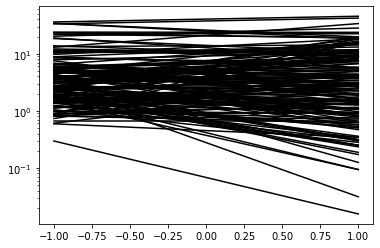

In [36]:
axes = plt.subplot()

barLoc = np.array([-1, 1])


for cellInd in range(nCells):
    plt.plot(barLoc, [celldb['baselineFiringRatePureTonesSaline'].iloc[cellInd], 
             celldb['baselineFiringRatePureTonesDOI'].iloc[cellInd]], '-', color = 'black')

plt.gca().set_yscale('log')

'''
plt.plot(np.tile(barLoc[0], nCells), celldb['baselineFiringRatePureTonesSaline'].iloc[cellInd], 'o', color = 'blue')
plt.plot(np.tile(barLoc[1], nCells), celldb['baselineFiringRatePureTonesDOI'].iloc[cellInd], 'o', color = 'red')


fontSize = 16
axes.set_xlim(barLoc[0] - 0.2, barLoc[1] + 0.2)
axes.set_xticks(barLoc)
axes.set_xticklabels(['saline', 'DOI'], fontsize = fontSize)
axes.set_ylabel("Average Firing Rate/s", fontsize = fontSize)
#axes.set_ylim()

extraplots.boxoff(axes)
extraplots.set_ticks_fontsize(axes, 10)
'''

In [50]:
celldb


,cluster,cluster_label,subject,date,brainArea,recordingTrack,probe,info,pdepth,ephysTime,...,upStandardSpikesAvgFiringRateSaline,upStandardSpikesAvgFiringRateDOI,gaussianAmplitudeSaline,gaussianAmplitudeDOI,gaussianMeanSaline,gaussianMeanDOI,gaussianSigmaSaline,gaussianSigmaeDOI,rSquaredColumnSaline,rSquaredColumnDOI
0,8,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,2.8,3.673469,1.920919,5.432271,12.644466,15.287712,0.869496,3.558867,0.182562,2.368310e-01
1,9,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,0.6,1.020408,2.095762,1.054112,13.138882,13.163812,1.350268,0.215371,0.384598,5.046322e-01
2,10,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,2.0,1.224490,0.649167,6.322928,13.828425,12.272035,0.911966,0.075355,0.048718,4.156674e-01
3,11,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,4.6,4.693878,5.766761,8.486221,12.435193,12.395813,1.795276,4.544434,0.496761,4.408039e-02
4,12,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,8.0,2.244898,6.884804,0.875805,12.749272,15.287712,3.699380,1.213066,0.025650,1.062133e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,528,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,0.2,0.204082,9.576997,1.722123,11.422155,13.041459,0.077877,0.207411,0.533893,4.120535e-01
155,539,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,4.4,9.591837,15.594951,3.024606,15.143648,11.249451,0.073861,0.047113,0.168753,3.419280e-01
156,541,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,4.4,3.673469,15.840702,5.892949,13.724886,12.007598,0.070001,0.200218,0.255871,5.653316e-01
157,542,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,0.2,0.000000,0.989593,0.088335,12.599089,13.190788,0.775353,0.005000,0.241734,-2.684434e-09


TuningFreq raster plots for DOI and saline

In [77]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
#sys.path.append('/Home/src/jaratest/maxh')
sys.path.append('C:/Users/mdhor/Documents/GitHub/jaratest/maxh')
import oddball_analysis_functions as odbl
from jaratoolbox import celldatabase
from jaratoolbox import settings
from jaratoolbox import ephyscore
from jaratoolbox import spikesanalysis
from jaratoolbox import extraplots
from jaratoolbox import behavioranalysis

timeRangePlot = [-0.3, 0.45]
timeRangeStim = [0.015, 0.115]
timeRangeBaseline = [-0.2, 0]
baselineDuration = timeRangeBaseline[1] - timeRangeBaseline[0]
stimDuration = timeRangeStim[1] - timeRangeStim[0]


subject = 'acid006'

inforecFile = os.path.join(settings.INFOREC_PATH, f'{subject}_inforec.py')

celldb = celldatabase.generate_cell_database(inforecFile)
dbPath = os.path.join(settings.DATABASE_PATH ,f'celldb_{subject}.h5')

reagents = ('saline', 'doi')
oddballSessions = ('FM_Up', 'FM_Down')

for indRow, dbRow in celldb.iterrows():
    oneCell = ephyscore.Cell(dbRow)

    fig = plt.figure(figsize=(8,10))
    gsMain = gs.GridSpec(2, 2, figure=fig)
    #gsOne = gs.GridSpecFromSubplotSpec(2, 1, subplot_spec = gsMain[0])
    #plt.subplots_adjust(hspace=0.50)

    ephysData, bdata = oneCell.load(f'salinePureTones')  
    spikeTimes = ephysData['spikeTimes']
    eventOnsetTimes = ephysData['events']['stimOn']


    frequencies_each_trial = bdata['currentFreq']
    array_of_frequencies = np.unique(bdata['currentFreq'])

    # Checks to see if trial count from bdata is the same as trial count from ephys
    if (len(frequencies_each_trial) > len(eventOnsetTimes)) or (len(frequencies_each_trial) < len(eventOnsetTimes)-1):
        print(f'Warning! BevahTrials ({len(frequencies_each_trial)}) and ' + f'EphysTrials ({len(eventOnsetTimes)})')
        sys.exit()

    # If the ephys data is 1 more than the bdata, delete the last ephys trial.
    if len(frequencies_each_trial) == len(eventOnsetTimes)-1:
        eventOnsetTimes = eventOnsetTimes[:len(frequencies_each_trial)]

    (spikeTimesFromEventOnsetSaline, trialIndexForEachSpikeSaline, indexLimitsEachTrialSaline) = spikesanalysis.eventlocked_spiketimes(spikeTimes, eventOnsetTimes, timeRangePlot)    

    trialsEachCondSaline = behavioranalysis.find_trials_each_type(frequencies_each_trial, array_of_frequencies)

    ephysData, bdata = oneCell.load(f'doiPureTones')  
    spikeTimes = ephysData['spikeTimes']
    eventOnsetTimes = ephysData['events']['stimOn']


    frequencies_each_trial = bdata['currentFreq']
    array_of_frequenciesDOI = np.unique(bdata['currentFreq'])

    # Checks to see if trial count from bdata is the same as trial count from ephys
    if (len(frequencies_each_trial) > len(eventOnsetTimes)) or (len(frequencies_each_trial) < len(eventOnsetTimes)-1):
        print(f'Warning! BevahTrials ({len(frequencies_each_trial)}) and ' + f'EphysTrials ({len(eventOnsetTimes)})')
        sys.exit()

    # If the ephys data is 1 more than the bdata, delete the last ephys trial.
    if len(frequencies_each_trial) == len(eventOnsetTimes)-1:
        eventOnsetTimes = eventOnsetTimes[:len(frequencies_each_trial)]

    (spikeTimesFromEventOnsetDOI, trialIndexForEachSpikeDOI, indexLimitsEachTrialDOI) = spikesanalysis.eventlocked_spiketimes(spikeTimes, eventOnsetTimes, timeRangePlot)    

    trialsEachCondDOI = behavioranalysis.find_trials_each_type(frequencies_each_trial, array_of_frequencies)
    
    spikeCountMatSaline = spikesanalysis.spiketimes_to_spikecounts(spikeTimesFromEventOnsetSaline, indexLimitsEachTrialSaline, timeRangeStim)
    spikeCountMatDOI = spikesanalysis.spiketimes_to_spikecounts(spikeTimesFromEventOnsetDOI, indexLimitsEachTrialDOI, timeRangeStim)

    nTrialsSaline = len(indexLimitsEachTrialSaline[0])
    nTrialsDOI= len(indexLimitsEachTrialDOI[0])

    #get trial index for each condition
    trialsEachCondIndsSaline, nTrialsEachCondSaline, nCondSaline= extraplots.trials_each_cond_inds(trialsEachCondSaline, nTrialsSaline)
    trialsEachCondIndsDOI, nTrialsEachCondDOI, nCondDOI= extraplots.trials_each_cond_inds(trialsEachCondDOI, nTrialsDOI)

    firingRatesSaline = np.empty(nCondSaline)
    for cond in range(nCondSaline):
        nSpikesEachTrial = spikeCountMatSaline[trialsEachCondSaline[:,cond]]
        avgSpikes = np.mean(nSpikesEachTrial)
        spikesFiringRate = (avgSpikes / stimDuration)
        firingRatesSaline[cond] = spikesFiringRate
   
    
    firingRatesDOI = np.empty(nCondDOI)
    for cond in range(nCondDOI):
        nSpikesEachTrial = spikeCountMatDOI[trialsEachCondDOI[:,cond]]
        avgSpikes = np.mean(nSpikesEachTrial)
        spikesFiringRate = (avgSpikes / stimDuration)
        firingRatesDOI[cond] = spikesFiringRate
   

    ax0 = plt.subplot(gsMain[0])
    plt.xlabel('Time (s)')
    plt.ylabel('Trials')
    plt.title('Saline tuningFreq Raster')
    fRaster = extraplots.raster_plot(spikeTimesFromEventOnsetSaline, indexLimitsEachTrialSaline, timeRangePlot, trialsEachCondSaline, labels = array_of_frequencies)

    ax1 = plt.subplot(gsMain[2], sharex = ax0)
    plt.xlabel('Time (s)')
    plt.ylabel('Trials')
    plt.title('DOI tuningFreq Raster')
    fRaster = extraplots.raster_plot(spikeTimesFromEventOnsetDOI, indexLimitsEachTrialDOI, timeRangePlot, trialsEachCondDOI, labels = array_of_frequencies)

    possibleLogFreq = np.log2(array_of_frequencies)

    try: 
        fitParamsSaline, RSquaredSaline = extraplots.fit_tuning_curve(possibleLogFreq, firingRatesSaline)
        fitParamsDOI, RSquaredDOI = extraplots.fit_tuning_curve(possibleLogFreq, firingRatesDOI)

        ax2 = plt.subplot(gsMain[1])
        pdots1,pfit1 = extraplots.plot_tuning_curve(array_of_frequencies, firingRatesSaline, fitParamsSaline)
        pfit1[0].set_color('blue')
        pdots1[0].set_color('blue')
        #plt.legend("Saline", "Dot")
        pdots2,pfit2 =extraplots.plot_tuning_curve(array_of_frequencies, firingRatesDOI, fitParamsDOI)
        pfit2[0].set_color('red')
        pdots2[0].set_color('red')
        #ax2.legend(['Saline', 'DOI'])
        
    

        figDirectory = os.path.join(settings.FIGURES_DATA_PATH, f'{subject}/tuningFreq')
        if not os.path.exists(figDirectory):
            os.makedirs(figDirectory)
        figName= f'{subject}_{reagent}_{dbRow.date}_{dbRow.maxDepth}um_c{dbRow.cluster}_tuningFreq.png'
        fileName = os.path.join(figDirectory, figName)

        #plt.show()
        plt.savefig(fileName, format='png')
        print(f'saving image {figName}')
        plt.close()
    except:
        print('fitParams error')
        plt.close()


print("done")


Generating database for /home/jarauser/src/jarainfo/inforecordings/acid006_inforec.py
Adding experiment from acid006 on 2023-03-22
saving image acid006_doi_2023-03-22_3000um_c8_tuningFreq.png
saving image acid006_doi_2023-03-22_3000um_c9_tuningFreq.png
saving image acid006_doi_2023-03-22_3000um_c10_tuningFreq.png
saving image acid006_doi_2023-03-22_3000um_c11_tuningFreq.png
saving image acid006_doi_2023-03-22_3000um_c12_tuningFreq.png
saving image acid006_doi_2023-03-22_3000um_c13_tuningFreq.png
saving image acid006_doi_2023-03-22_3000um_c14_tuningFreq.png
saving image acid006_doi_2023-03-22_3000um_c16_tuningFreq.png
saving image acid006_doi_2023-03-22_3000um_c17_tuningFreq.png
saving image acid006_doi_2023-03-22_3000um_c21_tuningFreq.png
saving image acid006_doi_2023-03-22_3000um_c26_tuningFreq.png
saving image acid006_doi_2023-03-22_3000um_c27_tuningFreq.png
saving image acid006_doi_2023-03-22_3000um_c33_tuningFreq.png
saving image acid006_doi_2023-03-22_3000um_c35_tuningFreq.png
sa

Raster and PSTH for FM DOWN/UP Oddball

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
sys.path.append('/home/jarauser/src/jaratest/maxh')
#sys.path.append('C:/Users/mdhor/Documents/GitHub/jaratest/maxh')
import oddball_analysis_functions as odbl
from jaratoolbox import celldatabase
from jaratoolbox import settings
from jaratoolbox import ephyscore
from jaratoolbox import spikesanalysis
from jaratoolbox import extraplots
from jaratoolbox import behavioranalysis

timeRangePlot = [-0.3, 0.45]
timeRangeStim = [0.015, 0.115]
timeRangeBaseline = [-0.2, 0]
baselineDuration = timeRangeBaseline[1] - timeRangeBaseline[0]
stimDuration = timeRangeStim[1] - timeRangeStim[0]

binWidth = 0.010
timeVec = np.arange(timeRangePlot[0],timeRangePlot[-1],binWidth)

oddballSessions = ('FM_Up', 'FM_Down')
reagents = ('saline', 'doi')


smoothWinSizePsth = 2 
lwPsth = 2
downsampleFactorPsth = 1

# Raster plot of high frequency
colorsEachCond = ['#39b5c4', '#f04158']
highFreqLabels = ('Standard', "Oddball")



subject = 'acid006'

inforecFile = os.path.join(settings.INFOREC_PATH, f'{subject}_inforec.py')

celldb = celldatabase.generate_cell_database(inforecFile)
dbPath = os.path.join(settings.DATABASE_PATH ,f'celldb_{subject}.h5')


for indRow, dbRow in celldb.iterrows():
    oneCell = ephyscore.Cell(dbRow)

    fig = plt.figure()
    gsMain = gs.GridSpec(2, 2, fig)


    if oneCell.get_session_inds(f'salineFM_Up') != []:
            (combinedSpikeTimesDown, combinedSpikeTimesUp, combinedIndexLimitsDown, combinedIndexLimitsUp, combinedTrialsDown, combinedTrialsUp, spikeCountMatDown, spikeCountMatUp) = odbl.prepare_plots(oneCell, timeRangePlot, 'salineFM_Down', 'salineFM_Up', timeVec)
            
            ax1 = plt.subplot(gsMain[0])
            # plt.xlabel('Time (s)')
            plt.ylabel('Trials')
            plt.title(f'saline FM_UP')
            ax1.tick_params(labelbottom=False) 
            pRaster, hcond, zline = extraplots.raster_plot(combinedSpikeTimesUp, combinedIndexLimitsUp, timeRangePlot, combinedTrialsUp, colorsEachCond, labels= highFreqLabels)
            for p in pRaster:
                p.set_markersize(2)


            ax2 = plt.subplot(gsMain[2], sharex=ax1)    
            extraplots.plot_psth(spikeCountMatUp/binWidth, smoothWinSizePsth, timeVec, combinedTrialsUp, colorsEachCond, linestyle=None, linewidth=lwPsth, downsamplefactor=downsampleFactorPsth)
            plt.xlabel('Time (s)')
            plt.ylabel('Firing Rate')
            plt.title(f'saline FM_UP')
            plt.legend(("Standard Tone", "Oddball Tone"), bbox_to_anchor=(-0.20, -0.20), loc = 'upper left', fontsize = 8)

            
            (combinedSpikeTimesDown, combinedSpikeTimesUp, combinedIndexLimitsDown, combinedIndexLimitsUp, combinedTrialsDown, combinedTrialsUp, spikeCountMatDown, spikeCountMatUp) = odbl.prepare_plots(oneCell, timeRangePlot, 'doiFM_Down', 'doiFM_Up', timeVec)
            
            ax3 = plt.subplot(gsMain[1])
            # plt.xlabel('Time (s)')
            plt.ylabel('Trials')
            plt.title(f'DOI FM_UP')
            ax1.tick_params(labelbottom=False) 
            pRaster, hcond, zline = extraplots.raster_plot(combinedSpikeTimesUp, combinedIndexLimitsUp, timeRangePlot, combinedTrialsUp, colorsEachCond, labels= highFreqLabels)
            for p in pRaster:
                p.set_markersize(2)


            ax4 = plt.subplot(gsMain[3], sharex=ax2)    
            extraplots.plot_psth(spikeCountMatUp/binWidth, smoothWinSizePsth, timeVec, combinedTrialsUp, colorsEachCond, linestyle=None, linewidth=lwPsth, downsamplefactor=downsampleFactorPsth)
            plt.xlabel('Time (s)')
            plt.ylabel('Firing Rate')
            plt.title(f'DOI FM_UP')
            plt.legend(("Standard Tone", "Oddball Tone"), bbox_to_anchor=(-0.20, -0.20), loc = 'upper left', fontsize = 8)


            figDirectory = os.path.join(settings.FIGURES_DATA_PATH, f'{subject}/oddball')
            if not os.path.exists(figDirectory):
                os.makedirs(figDirectory)
            figName= f'{subject}_{dbRow.date}_{dbRow.maxDepth}um_c{dbRow.cluster}_oddball.png'
            fileName = os.path.join(figDirectory, figName)

            plt.suptitle(f'{oneCell}', fontsize=16, fontweight='bold', y = 0.99)


            
            # Goes through each psth plot and calculutes the lowest and highest ylimit values.
            max_ylim = -np.inf
            min_ylim = np.inf
            for i, ax in enumerate(fig.get_axes()[1::2]):
                ylim = ax.get_ylim()
                if ylim[0] < min_ylim:
                    min_ylim = ylim[0]
                if ylim[1] > max_ylim:
                    max_ylim = ylim[1]
                
            # Iterates through each psth plot and changes the ylimits to the min and max ylimit.
            new_ylimits = [0, max_ylim]
            for i, ax in enumerate(fig.get_axes()[1::2]):
                ax.set_ylim(new_ylimits)
            

            #plt.show()
            plt.savefig(fileName, format='png')
            print(f'saving image {figName}')
            plt.close()



       

Plot summary (comparison) after loading the database that has tuning data.


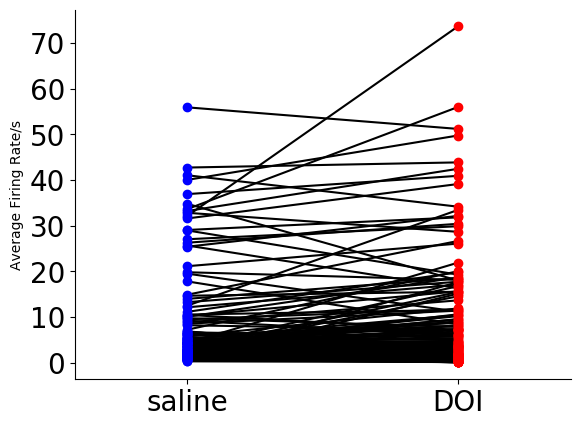

In [72]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
sys.path.append('/home/jarauser/src/jaratest/maxh')
#sys.path.append('C:/Users/mdhor/Documents/GitHub/jaratest/maxh')
import oddball_analysis_functions as odbl
from jaratoolbox import celldatabase
from jaratoolbox import settings
from jaratoolbox import ephyscore
from jaratoolbox import spikesanalysis
from jaratoolbox import extraplots
from jaratoolbox import behavioranalysis

filename = '/home/jarauser/Max/updatedAcid006.h5'
celldb = celldatabase.load_hdf(filename)


axes = plt.subplot()

barLoc = np.array([-0.24, 0.24])

averageFiringRateSaline= celldb['stimFiringRatePureTonesSaline']
averageFiringRateDOI= celldb['stimFiringRatePureTonesDOI']

for i in range(len(averageFiringRateSaline)):
    plt.plot(barLoc, [averageFiringRateSaline[i], averageFiringRateDOI[i]], '-', color = 'black')

plt.plot(np.tile(barLoc[0], len(averageFiringRateSaline)), averageFiringRateSaline, 'o', color = 'blue')
plt.plot(np.tile(barLoc[1], len(averageFiringRateDOI)), averageFiringRateDOI, 'o', color = 'red')


axes.set_xlim(barLoc[0] - 0.2, barLoc[1] + 0.2)
axes.set_xticks(barLoc)
axes.set_xticklabels(['saline', 'DOI'])
axes.set_ylabel("Average Firing Rate/s")
#axes.set_ylim(0,5)

extraplots.boxoff(axes)
extraplots.set_ticks_fontsize(axes, 20)
